In [34]:
# Template for weird data space model fitting with Stan
# Example: fitting "SPI-light" data to a model of background sky
import numpy as np
import matplotlib.pyplot as plt
import stan_utility
import pystan
import pickle
import sys
from IPython.display import Image
from IPython.display import Math
#plt.style.use('thomas')

<h3>"SPI-light" is a hypothetical instrument with two detectors which are block from the source light alternatingly for each pointing.<br>
    The background is (chosen) to be uniform.<br>
    A sketch of the setup is shown below.</h3>

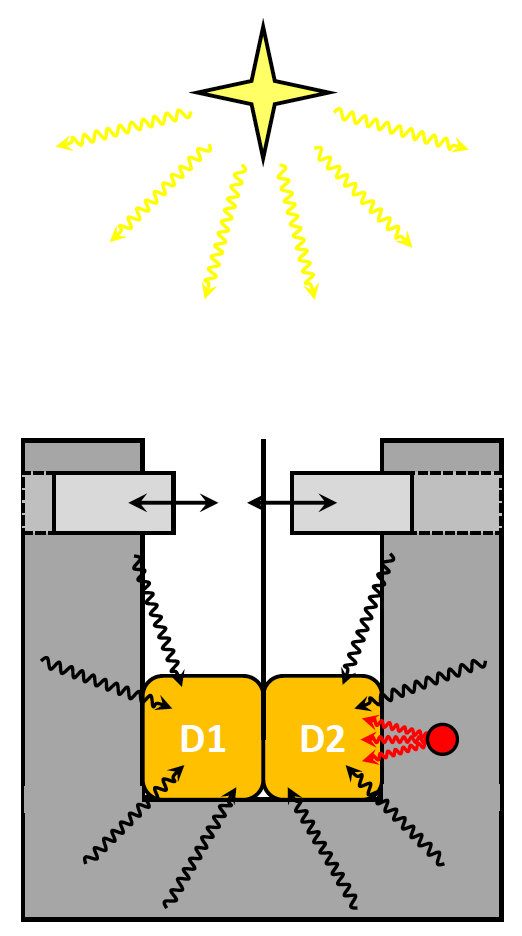

In [2]:
#plt.figure(figsize=(8,16))
with open('SPIlight.png','rb') as f:
    display(Image(data=f.read(), format='png',width=300),)

<h5>Background response</h5>

In [4]:
def R_BG(p): # pointing p
    return np.repeat(np.array([1.,1.]),len(p)).reshape(2,len(p)).T

<h5>Sky response</h5>

In [5]:
def R_SKY(p): # pointing p
    return np.array([1+(-1)**(p+1),1+(-1)**(p)]).T

<h5>Note the difference between background and sky response is that the R_BG is independent of p</h5>

<h5>We define 10 observation pointings 0..9</h5>

In [6]:
p = np.arange(10)

<h5>What do the responses look like?</h5>

In [7]:
R_SKY(p).shape,R_BG(p).shape

((10, 2), (10, 2))

<h5>10 values for each of the 2 detectors</h5>

<h5>Define a plotting function for this type of data:</h5>

In [9]:
def SPIl_plot(p,
              y,color='black',label=None,
              y2=None,color2='red',label2=None,
              y3=None,color3='red',label3=None):
    pp = np.sort(np.concatenate([p-0.5,p+0.5])) # array for plotting
    plt.step(pp,y.ravel(),color=color,label=label,where='mid')
    if np.any(y2 != None):
        plt.step(pp,y2.ravel(),color=color2,label=label2,where='mid')
    if np.any(y3 != None):
        plt.step(pp,y3.ravel(),color=color3,label=label3,where='mid')
    for i in range(len(p)+1):
        plt.axvline(i-0.5,linestyle='--',color='black')
    plt.xlabel('Pointing number')
    plt.ylabel('Counts')
    plt.legend()

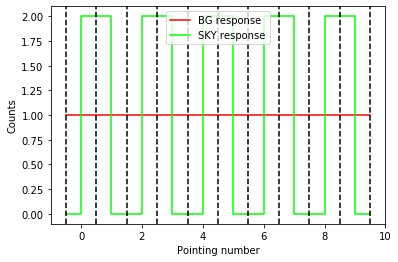

In [10]:
SPIl_plot(p,
          R_BG(p),color='red',label='BG response',
          y2=R_SKY(p),color2='lime',label2='SKY response')

<h5>Here, each pair of vertical lines defines one pointing in which the background response (red) predicts 1 count in each detector.<br>
    The sky response predicts either 0 and 2 in a pointing (even numbered) or 2 and 0 (odd numbered).</h5>

<h5>Now create data</h5>

In [11]:
true_sky = 3.
true_bg = 30.

y_true = true_sky*R_SKY(p) + true_bg*R_BG(p)
yp = np.random.poisson(y_true)

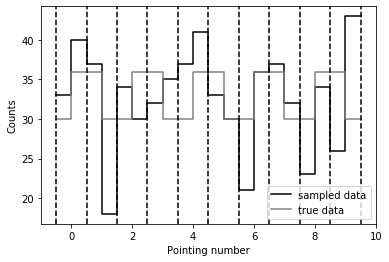

In [12]:
SPIl_plot(p,
          yp,color='black',label='sampled data',
          y2=y_true,color2='gray',label2='true data')

In [13]:
"""## compile model (if not yet compiled):
model = pystan.StanModel('spimodfit.stan')

## save it to the file 'filename.pkl' for later use
with open('spimodfit.pkl', 'wb') as f:
    pickle.dump(model, f)"""
    
#read filename.pkl (if already compiled)
model = pickle.load(open('spimodfit.pkl', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'spimodfit.pkl'

<h5>We used python functions to create the data, now we use our known responses to input to the fit:</h5>

<h5>For our background model to work, we have to identify and transfer change points (if any). This is done by the following function (details later).</h5>

In [14]:
def make_bg_cuts(cuts,Np):
    cuts = [1] + cuts + [1e99]
    bg_cuts = np.zeros(Np)
    cidx = 0
    for i in range(1,Np+1):
        #print(i)
        if (cuts[cidx] <= i < cuts[cidx+1]):
            bg_cuts[i-1] = cuts[cidx]
        else:
            cidx += 1
            bg_cuts[i-1] = cuts[cidx]
            
    Ncuts = len(np.unique(bg_cuts))
    idx_arr = np.ones(Np)
    for i in range(Ncuts):
        idx_arr[np.where(bg_cuts == cuts[i+1])[0]] = i+1
    
    return bg_cuts.astype(int), idx_arr.astype(int), Ncuts

<h5>Two examples for comprehension:</h5>

In [15]:
bg_cuts, idx_arr, Ncuts = make_bg_cuts([1],10) # for 10 pointings, use only one time node (== constant BG)
# (python's first index is zero, Stan's is 1 (!))

In [16]:
bg_cuts,idx_arr,Ncuts

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 1)

In [17]:
bg_cuts, idx_arr, Ncuts = make_bg_cuts([1,3,8],10) # for 10 pointings, use three time nodes at 1,3,8
bg_cuts,idx_arr,Ncuts

(array([1, 1, 3, 3, 3, 3, 3, 8, 8, 8]),
 array([1, 1, 2, 2, 2, 2, 2, 3, 3, 3]),
 3)

In [163]:
Np, Nrsp = R_BG(p).shape         # initialise sizes of arrays
N = Np*Nrsp                      # total number of data points

mu_flux_scl = np.array([10.])    # prior centroids for sky, we use 10 because we are ignorant;
# this has to be an array because it could be more than one
sigma_flux_scl = np.array([10.]) # same for the width (so, easily 0 but also high values possible)
mu_Abg = 30.                     # for the moment set to a useful value (because we didn't do anything else, yet)
sigma_Abg = 30.                  # same


# background cuts (here only one parameter for all times)
bg_cuts, idx_arr, Ncuts = make_bg_cuts([1],Np)

# dictionary for data set and prior
data2D = dict(N = Nrsp,
              Np = Np,
              Nsky = 1,
              Ncuts = Ncuts,
              bg_cuts = bg_cuts,
              bg_idx_arr = idx_arr,
              y = yp.ravel().astype(int),
              bg_model = R_BG(p),
              conv_sky = R_SKY(p).reshape(1,10,2), # this has to be reshaped because it could be more than one
              mu_flux = mu_flux_scl,
              sigma_flux = sigma_flux_scl,
              mu_Abg = mu_Abg,
              sigma_Abg = sigma_Abg)

In [18]:
import time

<h5>Now, let's only optimise the posterior and plot the result:</h5>

In [19]:
init = {}
init['flux'] = np.array([1.0])
init['Abg'] = np.repeat(30,Ncuts)
start = time.time()
op = model.optimizing(data=data2D,verbose=True,init=init,as_vector=False,tol_rel_grad=1e4)
print(time.time()-start)
op

NameError: name 'model' is not defined

<h5>The result dictionary (op) includes all the information that we generated in the Stan model.<br>
    The PPC and posterior models don't make much sence without the posterior distributions, but we get a value for the flux and the background amplitude (again, without uncertainties):</h5>

In [20]:
fitted_model = op['par']['model_values'].reshape((Np,Nrsp))

NameError: name 'op' is not defined

In [21]:
fitted_model.shape

NameError: name 'fitted_model' is not defined

In [22]:
SPIl_plot(p,
          yp,color='black',label='sampled data',
          y2=y_true,color2='gray',label2='true data',
          y3=fitted_model,color3='red',label3='fitted model')

NameError: name 'fitted_model' is not defined

<h5>Magic? Let's check out the sampling></h5>

In [23]:
op2 = model.sampling(data=data2D,chains=1,iter=5000,n_jobs=-1,verbose=True)#,pars=['flux','Abg']

NameError: name 'model' is not defined

In [170]:
op2

Inference for Stan model: anon_model_c2e0aba85727555652db8ac183ad91d8.
1 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=2500.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]            2.99    0.04   1.27   0.57   2.13   2.95   3.84   5.54    861    1.0
Abg[1]            31.11    0.06   1.72  27.69  29.96   31.1  32.23  34.55    771    1.0
model_values[1]   31.11    0.06   1.72  27.69  29.96   31.1  32.23  34.55    771    1.0
model_values[2]   37.08    0.04   1.89  33.56  35.79   37.0  38.34  41.01   2038    1.0
model_values[3]   37.08    0.04   1.89  33.56  35.79   37.0  38.34  41.01   2038    1.0
model_values[4]   31.11    0.06   1.72  27.69  29.96   31.1  32.23  34.55    771    1.0
model_values[5]   31.11    0.06   1.72  27.69  29.96   31.1  32.23  34.55    771    1.0
model_values[6]   37.08    0.04   1.89  33.56  35.79   37.0  38.34  41.01   2038    1.0
model_values[7]   3

<h5>This is a lot of information.<br>
    Let's walk through this:<br>
    flux[1] and Abg[1] are our parameters of interest with fitted (mean or median (= 50% percentile)) value and uncertainty (e.g. standard deviation of the posterior distribution (sd) or whatever percentile you like).<br>
    model_values[1..20] are the fitted model values for each data point (!) with their respective uncertainties from the fitted parameters, their uncertainties, and the data.<br>
    ppc[1..20] are the posterior predictive values (= new data drawn from the model values) for each data points.<br>
    model_tot[1..10] are the total model counts, summed over the data space bins (here 2 detectors), i.e. the total number of photons per pointing.<br>
    model_bg[1..10] and model_sky[1..10] are the same as model_tot[1..0] but split into the individual model components.<br>
    Finally, lp__ is the log-posterior of the fit.</h5>

<h5>What do our posterior distributions for flux and Abg look like?</h5>

In [24]:
op2.plot(['flux','Abg']);
plt.tight_layout()

NameError: name 'op2' is not defined

<h5>Clearly, our sky signal is not very "significant" (why?)</h5>

<h5>PPCs of complete data set (all data points):</h5>

In [25]:
pp = np.sort(np.concatenate([p-0.5,p+0.5])) # array for plotting

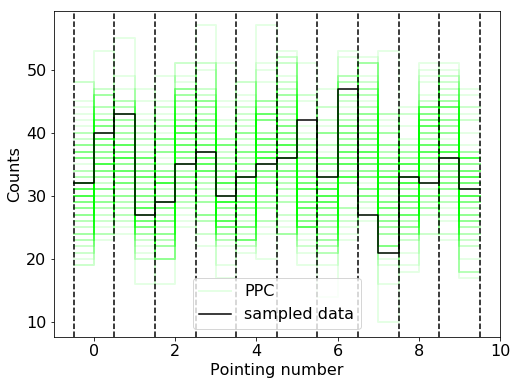

In [173]:
"""
plt.step(pp,np.percentile(op2['ppc'],50,axis=0),color='green',where='mid',label='median model')
plt.fill_between(pp,
         np.percentile(op2['ppc'],50-68.3/2,axis=0),
         np.percentile(op2['ppc'],50+68.3/2,axis=0),step='mid',color='lime',alpha=0.4,label='PPC (68th)')
plt.fill_between(pp,
         np.percentile(op2['ppc'],50-95.4/2,axis=0),
         np.percentile(op2['ppc'],50+95.4/2,axis=0),step='mid',color='lime',alpha=0.2,label='PPC (95th)')
"""
for i in range(0,2500,25):
    plt.step(pp,op2['ppc'][i,:],
             alpha=0.1,where='mid',color='lime',linewidth=2)
plt.step(pp,op2['ppc'][i,:],alpha=0.1,where='mid',color='lime',linewidth=2,label='PPC')

SPIl_plot(p,
          yp,color='black',label='sampled data')

<h5>PPC in only time domain></h5>

In [26]:
for i in range(0,2500,25):
    plt.step(p,np.sum(op2['ppc'][i,:].reshape((Np,Nrsp)),axis=1),
             alpha=0.1,where='mid',color='lime',linewidth=2)
plt.step(p,np.sum(op2['ppc'][i,:].reshape((Np,Nrsp)),axis=1),alpha=0.1,where='mid',color='lime',linewidth=2,label='PPC (time domain)')

plt.step(p,np.sum(yp,axis=1),color='black',label='sampled data (time domain)',where='mid')

for i in range(len(p)+1):
    plt.axvline(i-0.5,linestyle='--',color='black')
plt.xlabel('Pointing number')
plt.ylabel('Counts')
plt.legend()

NameError: name 'op2' is not defined

<h5>Model posterior (all data points)<br>
    (Do you understand the difference?)</h5>

In [27]:

plt.step(pp,np.percentile(op2['model_values'],50,axis=0),color='green',where='mid',label='median model')
plt.fill_between(pp,
         np.percentile(op2['model_values'],50-68.3/2,axis=0),
         np.percentile(op2['model_values'],50+68.3/2,axis=0),step='mid',color='lime',alpha=0.4,label='fitted model (68th)')
plt.fill_between(pp,
         np.percentile(op2['model_values'],50-95.4/2,axis=0),
         np.percentile(op2['model_values'],50+95.4/2,axis=0),step='mid',color='lime',alpha=0.2,label='fitted model (95th)')

SPIl_plot(p,
          yp,color='black',label='sampled data')

NameError: name 'op2' is not defined

<h5>Model posterior (individual components, only time domain):</h5>

In [28]:

plt.fill_between(p,
         np.percentile(op2['model_tot'],50-68.3/2,axis=0),
         np.percentile(op2['model_tot'],50+68.3/2,axis=0),step='mid',color='gray',alpha=0.6,label='fitted total model (68th)')
plt.fill_between(p,
         np.percentile(op2['model_tot'],50-95.4/2,axis=0),
         np.percentile(op2['model_tot'],50+95.4/2,axis=0),step='mid',color='gray',alpha=0.2,label='fitted total model (95th)')
plt.fill_between(p,
         np.percentile(op2['model_bg'],50-68.3/2,axis=0),
         np.percentile(op2['model_bg'],50+68.3/2,axis=0),step='mid',color='red',alpha=0.2,label='fitted bg model (68th)')
plt.fill_between(p,
         np.percentile(op2['model_sky'],50-68.3/2,axis=(0,1)),
         np.percentile(op2['model_sky'],50+68.3/2,axis=(0,1)),step='mid',color='lime',alpha=0.2,label='fitted sky model (68th)')

plt.step(p,np.sum(yp,axis=1),color='black',label='sampled data',where='mid')

for i in range(len(p)+1):
    plt.axvline(i-0.5,linestyle='--',color='black')
plt.xlabel('Pointing number')
plt.ylabel('Counts')
plt.legend(loc=6)

NameError: name 'op2' is not defined

<h5>Example with scaling every pointing:</h5>

In [29]:
Np, Nrsp = R_BG(p).shape         # initialise sizes of arrays
N = Np*Nrsp                      # total number of data points

mu_flux_scl = np.array([10.])    # prior centroids for sky, we use 10 because we are ignorant;
# this has to be an array because it could be more than one
sigma_flux_scl = np.array([10.]) # same for the width (so, easily 0 but also high values possible)
mu_Abg = 30.                     # for the moment set to a useful value (because we didn't do anything else, yet)
sigma_Abg = 30.                  # same


# background cuts (here only one parameter for all times)
#bg_cuts, idx_arr, Ncuts = make_bg_cuts([1,6],Np)
bg_cuts, idx_arr, Ncuts = make_bg_cuts(list(np.arange(0,10,1)+1),Np)

# dictionary for data set and prior
data2D = dict(N = Nrsp,
              Np = Np,
              Nsky = 1,
              Ncuts = Ncuts,
              bg_cuts = bg_cuts,
              bg_idx_arr = idx_arr,
              y = yp.ravel().astype(int),
              bg_model = R_BG(p),
              conv_sky = R_SKY(p).reshape(1,10,2), # this has to be reshaped because it could be more than one
              mu_flux = mu_flux_scl,
              sigma_flux = sigma_flux_scl,
              mu_Abg = mu_Abg,
              sigma_Abg = sigma_Abg)

In [30]:
op3 = model.sampling(data=data2D,chains=1,iter=5000,n_jobs=-1,verbose=True)#,pars=['flux','Abg'])

NameError: name 'model' is not defined

In [31]:
op3

NameError: name 'op3' is not defined

<h5>Now we have 10(!) background parameters, one for each pointing.</h5>

In [32]:
op3.plot(['flux','Abg']);
plt.tight_layout()

NameError: name 'op3' is not defined

<h5>Model posterior (all data points)</h5>

In [33]:
plt.step(pp,np.percentile(op3['model_values'],50,axis=0),color='green',where='mid',label='median model')
plt.fill_between(pp,
         np.percentile(op3['model_values'],50-68.3/2,axis=0),
         np.percentile(op3['model_values'],50+68.3/2,axis=0),step='mid',color='lime',alpha=0.4,label='fitted model (68th)')
plt.fill_between(pp,
         np.percentile(op3['model_values'],50-95.4/2,axis=0),
         np.percentile(op3['model_values'],50+95.4/2,axis=0),step='mid',color='lime',alpha=0.2,label='fitted model (95th)')

SPIl_plot(p,
          yp,color='black',label='sampled data')

NameError: name 'op3' is not defined

<h5>PPC (all data points)</h5>

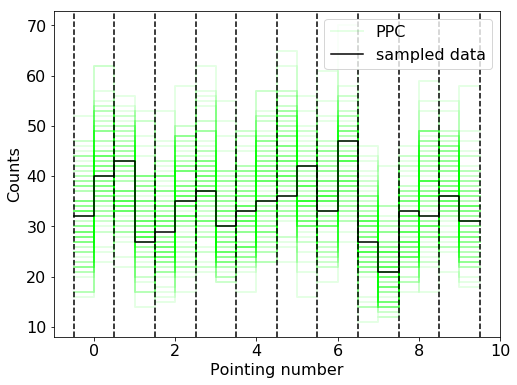

In [182]:
for i in range(0,2500,25):
    plt.step(pp,op3['ppc'][i,:],
             alpha=0.1,where='mid',color='lime',linewidth=2)
plt.step(pp,op3['ppc'][i,:],alpha=0.1,where='mid',color='lime',linewidth=2,label='PPC')

SPIl_plot(p,
          yp,color='black',label='sampled data')

<h5>PPC (time)</h5>

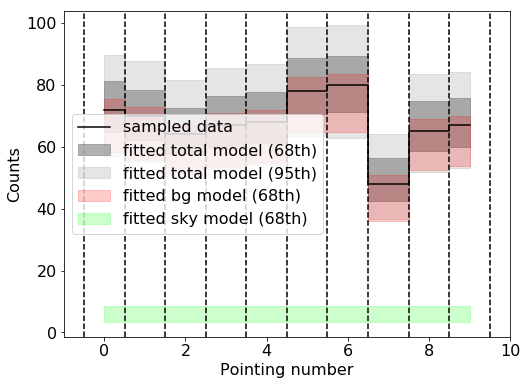

In [183]:
plt.fill_between(p,
         np.percentile(op3['model_tot'],50-68.3/2,axis=0),
         np.percentile(op3['model_tot'],50+68.3/2,axis=0),step='mid',color='gray',alpha=0.6,label='fitted total model (68th)')
plt.fill_between(p,
         np.percentile(op3['model_tot'],50-95.4/2,axis=0),
         np.percentile(op3['model_tot'],50+95.4/2,axis=0),step='mid',color='gray',alpha=0.2,label='fitted total model (95th)')
plt.fill_between(p,
         np.percentile(op3['model_bg'],50-68.3/2,axis=0),
         np.percentile(op3['model_bg'],50+68.3/2,axis=0),step='mid',color='red',alpha=0.2,label='fitted bg model (68th)')
plt.fill_between(p,
         np.percentile(op3['model_sky'],50-68.3/2,axis=(0,1)),
         np.percentile(op3['model_sky'],50+68.3/2,axis=(0,1)),step='mid',color='lime',alpha=0.2,label='fitted sky model (68th)')

plt.step(p,np.sum(yp,axis=1),color='black',label='sampled data',where='mid')

for i in range(len(p)+1):
    plt.axvline(i-0.5,linestyle='--',color='black')
plt.xlabel('Pointing number')
plt.ylabel('Counts')
plt.legend(loc=6)

<h5>Did we overfit? How do we check that? What is optimal?</h5>

<h5>Let's define possible background time nodes (cuts), i.e. every 10, 5, 3, 2, 1 pointings:</h5>

In [184]:
all_cuts = [list(range(1,Np+1,int(Np/i))) for i in list(range(1,Np+1))]
all_cuts_unique = np.unique(all_cuts)

all_cuts_unique

array([list([1]), list([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
       list([1, 3, 5, 7, 9]), list([1, 4, 7, 10]), list([1, 6])],
      dtype=object)

<h5>Here, we define the figure of merit "Cash statistic" (Cash 1979), i.e. the log-Poisson likelihood.<br>
    In addition, we define the Akaike Information Criterion (Akaike 1974) that penalises too many fitted parameters in a fit:</h5>

In [185]:
def AIC(n_par, lnlik):
    return (2*n_par) - (2*lnlik)

def cashstat(data,model):
    return -2*np.sum(data*np.log(model)-model-(data*np.nan_to_num(np.log(data))-data))

<h5>Now we loop over all chosen background settings and record/calculate the cash stat (note: no sampling needed, the optimum point is enough):</h5>

In [186]:
cstat_arr = []
for c in range(len(all_cuts_unique)):
    bg_cuts, idx_arr, Ncuts = make_bg_cuts(all_cuts_unique[c],Np)

    # dictionary for data set and prior
    data2D = dict(N = Nrsp,
                  Np = Np,
                  Nsky = 1,
                  Ncuts = Ncuts,
                  bg_cuts = bg_cuts,
                  bg_idx_arr = idx_arr,
                  y = yp.ravel().astype(int),
                  bg_model = R_BG(p),
                  conv_sky = R_SKY(p).reshape(1,10,2), # this has to be reshaped because it could be more than one
                  mu_flux = mu_flux_scl,
                  sigma_flux = sigma_flux_scl,
                  mu_Abg = mu_Abg,
                  sigma_Abg = sigma_Abg)
    
    init = {}
    init['Abg'] = np.repeat(1,Ncuts)
    init['flux'] = np.array([1.0])
    op_tmp = model.optimizing(data=data2D,verbose=True,init=init,as_vector=False,tol_rel_grad=1e4)
    cstat_arr.append(cashstat(yp.ravel(),op_tmp['par']['model_values']))
cstat_arr = np.array(cstat_arr)

<h5>Number of fitted parameters (note: also the sky model scaling counts):</h5>

In [187]:
n_par_arr = np.zeros(len(all_cuts_unique))
for c in range(len(all_cuts_unique)):
    _, _, n_par_arr[c] = make_bg_cuts(all_cuts_unique[c],Np)
n_par_arr += 1

<h5>Sort array to get monotonic function (not required but can make visualisation easier):</h5>

In [188]:
so = np.argsort(n_par_arr)
n_par_arr = n_par_arr[so]

Text(0, 0.5, 'AIC')

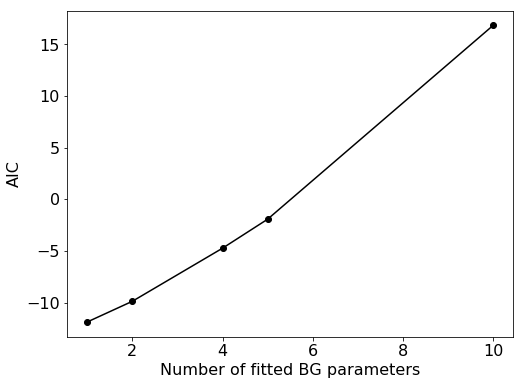

In [189]:
plt.plot(n_par_arr-1,AIC(n_par_arr,cstat_arr[so]/2),'o-')
plt.xlabel('Number of fitted BG parameters')
plt.ylabel('AIC')

<h5>???<br>
    The absolute value of the AIC has (nearly) no meaning, only the relative values:<br>
    The lowest AIC is, among the tested scenarios, indicating the most probable model.<br>
    Here, this is the configuration with only one background scaling parameters.<br>
    This is expected as we included a constant background model, so, everything works as expected.</h5>

<h3>Now, if we don't know the BG response but only the SKY response (from simulation, or ground measurements), can we extract the same information from the data themselves?</h3>

<h5>Sum data set over all times/pointings and create a background response (expected number of counts in data space bins, relative to each other, normalised to a common value, here number of detectors):</h5>

In [190]:
def R_BG_from_data(y,norm,p):
    return np.repeat(np.sum(y,axis=0)/np.sum(y)*norm,len(p)).reshape(2,len(p)).T

In [191]:
R_BG_from_data(yp,2,p)[0,:],R_BG(p)[0,:]

(array([0.99852725, 1.00147275]), array([1., 1.]))

(0, 2)

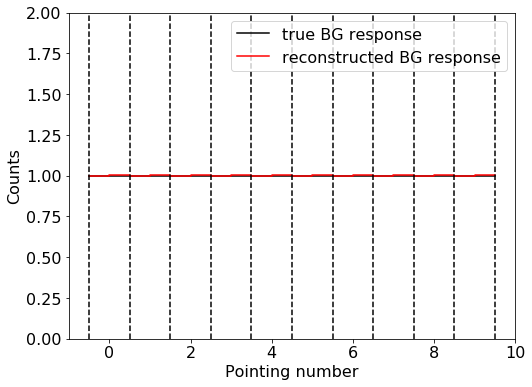

In [192]:
SPIl_plot(p,R_BG(p),color='black',label='true BG response',
          y2=R_BG_from_data(yp,2,p),color2='red',label2='reconstructed BG response')
plt.ylim(0,2)

<h5>As you can see, the sky signal smears out, and the resulting BG response is nearly identical to what we would put in in the first place.<br>
    Now running through the fits and comparing results:</h5>

In [193]:
# the only thing that is changed here is the background response, now being calculate from the data
# the rest stays the same
Np, Nrsp = R_BG_from_data(yp,2,p).shape         # initialise sizes of arrays
N = Np*Nrsp                                     # total number of data points

mu_flux_scl = np.array([10.])    # prior centroids for sky, we use 10 because we are ignorant;
# this has to be an array because it could be more than one
sigma_flux_scl = np.array([10.]) # same for the width (so, easily 0 but also high values possible)
mu_Abg = 30.                     # for the moment set to a useful value (because we didn't do anything else, yet)
sigma_Abg = 30.                  # same


# background cuts (here only one parameter for all times)
bg_cuts, idx_arr, Ncuts = make_bg_cuts([1],Np)
#bg_cuts, idx_arr, Ncuts = make_bg_cuts(list(np.arange(0,10,1)+1),Np)

# dictionary for data set and prior
data2D = dict(N = Nrsp,
              Np = Np,
              Nsky = 1,
              Ncuts = Ncuts,
              bg_cuts = bg_cuts,
              bg_idx_arr = idx_arr,
              y = yp.ravel().astype(int),
              bg_model = R_BG_from_data(yp,2,p),
              conv_sky = R_SKY(p).reshape(1,10,2), # this has to be reshaped because it could be more than one
              mu_flux = mu_flux_scl,
              sigma_flux = sigma_flux_scl,
              mu_Abg = mu_Abg,
              sigma_Abg = sigma_Abg)

In [194]:
op4 = model.sampling(data=data2D,chains=1,iter=5000,n_jobs=-1,verbose=True,pars=['flux','Abg'])

In [195]:
op4

Inference for Stan model: anon_model_c2e0aba85727555652db8ac183ad91d8.
1 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=2500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]   2.94    0.05   1.26   0.55   2.11   2.91   3.75   5.51    696    1.0
Abg[1]   31.17    0.06   1.76  27.79  29.97  31.17  32.35  34.66    761    1.0
lp__    1719.9    0.05   1.24 1716.4 1719.5 1720.3 1720.8 1721.1    601   1.01

Samples were drawn using NUTS at Wed Jun 24 12:44:47 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

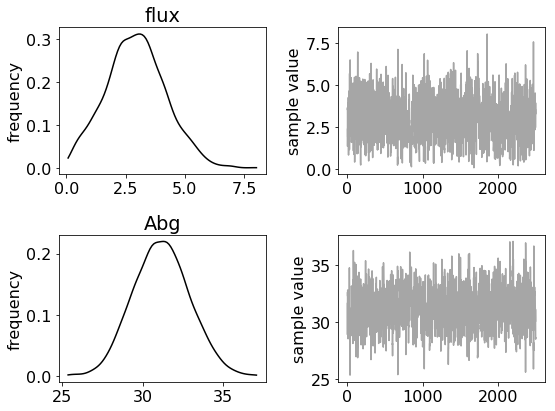

In [196]:
op4.plot()
plt.tight_layout()

In [197]:
print('True BG response results: \nflux = %2.2f+-%2.2f; Abg = %2.2f+-%2.2f' %
      (np.mean(op2['flux']),np.std(op2['flux']),
      np.mean(op2['Abg']),np.std(op2['Abg'])))

True BG response results: 
flux = 2.99+-1.27; Abg = 31.11+-1.72


In [198]:
print('Constructed BG response results: \nflux = %2.2f+-%2.2f; Abg = %2.2f+-%2.2f' %
      (np.mean(op4['flux']),np.std(op4['flux']),
      np.mean(op4['Abg']),np.std(op4['Abg'])))

Constructed BG response results: 
flux = 2.94+-1.26; Abg = 31.17+-1.76


In [199]:
print('True values: \nflux = %2.2f; Abg = %2.2f' %
      (true_sky,true_bg))

True values: 
flux = 3.00; Abg = 30.00


In [107]:
model.show()

StanModel object 'anon_model_c2e0aba85727555652db8ac183ad91d8' coded as follows:
data {

// this is the input data that is given from python to stan via a dictionary
    
    int<lower=0> N;           // number of response matrix points (data space bins = number of detectors) times number of pointings in data set
    int<lower=0> Np;          // number of pointings in observation data set
    int<lower=0> y[Np*N];     // y observations = counts in each data space bin (data)
    int<lower=1> Nsky;        // number of sky models (at least one model to be fitted; note these are already convolved)

    real bg_model[Np,N];      // BG model (response) for each pointing and detector (any tracer already applied; renormalisation fitted; time nodes fixed below)
    real conv_sky[Nsky,Np,N]; // SKY model(s) (already convolved)
  
    // background re-normalisation times
    int<lower=0> Ncuts;       // number of time nodes where/when the background is rescaled
    int bg_cuts[Np];          // tr